# Ridge regression model for the king country houses dataset

In [7]:
# 📚 Basic Libraries
import pandas as pd
import numpy as np

# 📊 Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# 🤖 Scikit-learn modules for modeling and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
data = pd.read_csv(r"C:\Users\Vanuhi\Documents\v4nui\IH_individual_projects\mini-project-ironkaggle\dataset\king_country_houses_aa.csv")
df = data.copy()
df.head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062


In [4]:
continuous_columns = []
continuous_columns.append('price')
continuous_columns.append('sqft_lot')
continuous_columns.append('sqft_lot15')
continuous_columns.append('sqft_above')
continuous_columns.append('sqft_basement')
continuous_columns.append('sqft_living')
continuous_columns.append('lat')
continuous_columns.append('long')
continuous_columns

['price',
 'sqft_lot',
 'sqft_lot15',
 'sqft_above',
 'sqft_basement',
 'sqft_living',
 'lat',
 'long']

### Correlation of numeric continous features with price(target)

In [5]:
df[continuous_columns].corr()["price"].sort_values(ascending=True)

long             0.021626
sqft_lot15       0.082447
sqft_lot         0.089661
lat              0.307003
sqft_basement    0.323816
sqft_above       0.605567
sqft_living      0.702035
price            1.000000
Name: price, dtype: float64

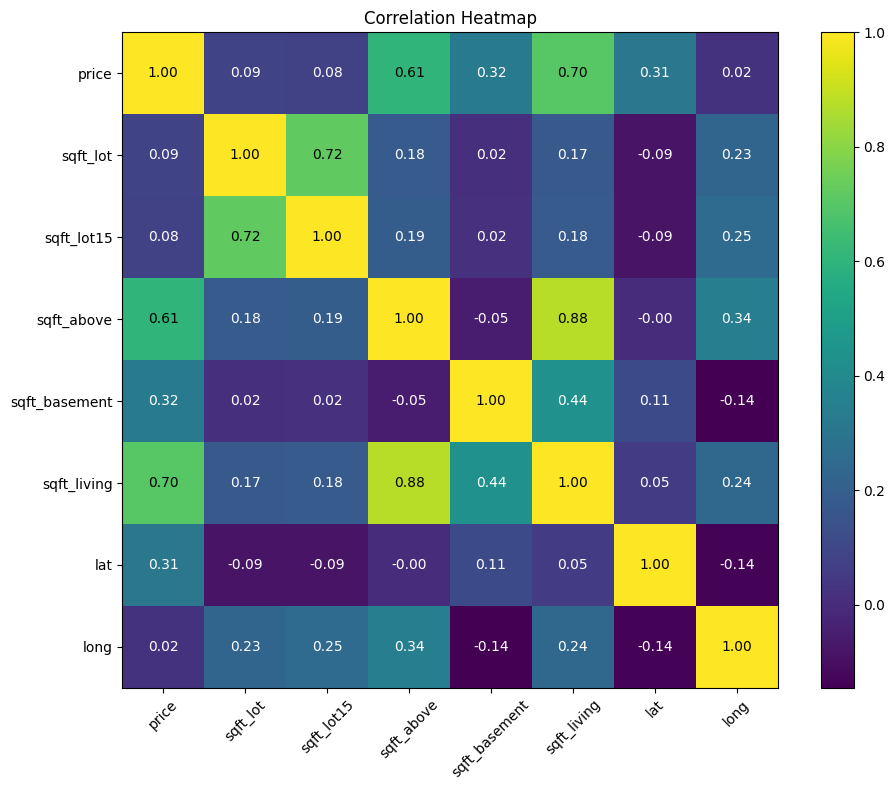

In [6]:
corr_matrix = df[continuous_columns].corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='viridis', interpolation='nearest')
plt.title('Correlation Heatmap')
plt.colorbar()

# set tick marks and labels
tick_marks = np.arange(len(corr_matrix.columns))
plt.xticks(tick_marks, corr_matrix.columns, rotation=45)
plt.yticks(tick_marks, corr_matrix.columns)

# add text annotations for each cell
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                 ha='center', va='center',
                 color='white' if corr_matrix.iloc[i, j] < 0.5 else 'black')

plt.tight_layout()
plt.show()


## Focus: Ridge regression
1. Defining the features and target.

In [8]:
features = ['long', 'sqft_lot15', 'sqft_lot', 'lat', 'sqft_basement', 'sqft_above', 'sqft_living']
target = 'price'

X = df[features]
y = df[target]

2. Split the dataset into training and testing sets.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

3. Create a pipeline that scales the data then applies Ridge Regression.

In [10]:
pipeline = make_pipeline(StandardScaler(), Ridge())

4. Set up a grid search to find the best alpha (lambda in math (regularization strength)).

In [12]:
# alpha controls the amount of shrinkage: higher alpha -> more regularization
param_grid = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}

ridge_cv = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

5. Evaluate the model on both training and testing data.

Train R2 Score: 0.5807878438139961
Test R2 Score: 0.5777286593495239
Train MSE: 54769487073.83489
Test MSE: 63837592959.8341


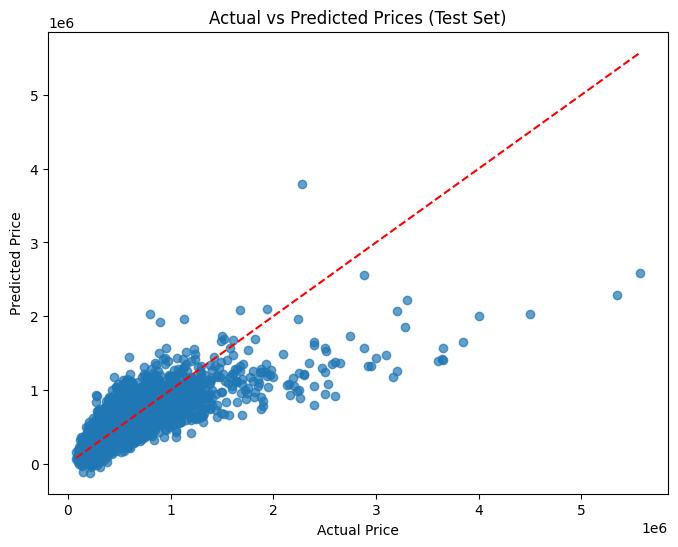

In [14]:
y_train_pred = ridge_cv.predict(X_train)
y_test_pred = ridge_cv.predict(X_test)

print("Train R2 Score:", r2_score(y_train, y_train_pred))
print("Test R2 Score:", r2_score(y_test, y_test_pred))
print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))

# Plot Actual vs Predicted prices for the test set
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices (Test Set)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.show()